In [1]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.setrecursionlimit(100000)

In [2]:
#define your observation, forward simulation and da simulation root path
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/NOAA_GHRSST/'
mynlroot = '/Volumes/WD_3/'
mydaroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/'
#define your workspace 
nl_workspace = 'outputs_SCORRECTION/outputs_201205/'
da_workspace = 'workspace_geopolarsst/'
obs_workspace = '2012/'
#define your filenames
obs_file='noaacwBLENDEDsstDaily_2012.nc'
nl_files = "*avg*.nc"
 #since this is a sst validation, only qck file is needed
prior_files = "/STORAGE/prior/*qck*.nc"
posterior_files = "/STORAGE/posterior/*qck*.nc"

In [3]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2012-09-01-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 'analysed_sst'
# 2d situation
model_var = 'temp_sur' 
#3d situation
# model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))



duration to be validated: from 2012-05-01-12H to 2012-09-01-12H, total of 124 days.
         target obs variable: analysed_sst
         target model variable: temp_sur


In [ ]:
# lauching the dask workstation
# client = Client(threads_per_worker=8, n_workers=4,memory_limit= '8 GiB')
# print(client.dashboard_link)

In [ ]:
# client.close()

In [4]:
# loading observation data
Obs_ds = xr.open_mfdataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                           # chunks={'longitude':260,'latitude':210},
                           parallel=True).chunk(dict(time=-1))
Obs_data = Obs_ds[obs_var].isel(time=slice(0,data_len))
Obs_data = Obs_data-273.15 # turn to ceilcus
# Obs_data

In [5]:
# loading forward sst
start = time.time()
fwd_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))
# for forward there is no qck file ,so the model var has only 'temp'
# further we only want the surface data, so the s_rho = -1
fwd_data = fwd_ds['temp'].sel(ocean_time=slice(start_date,end_date)).isel(s_rho=-1)
# always drop the initial time of posterior since there is a jump
fwd_data = fwd_data.drop_duplicates(dim='ocean_time',keep='first')
# fwd_data


loading costing 0.748788 min


In [6]:
# loading prior sst
start = time.time()
prior_ds = xr.open_mfdataset(mydaroot+da_workspace+prior_files,
                             engine='netcdf4',coords='minimal',
                             parallel=True,
                             # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                             #             # 's_rho':z_chunk, # only 3d needed
                             #               'eta_u':y_chunk,'xi_u':x_chunk,\
                             #               'eta_v':y_chunk,'xi_v':x_chunk,\
                             #               'eta_psi':y_chunk,'xi_psi':x_chunk,},
                            )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))
prior_data = prior_ds[model_var].sel(ocean_time=slice(start_date,end_date))
# always drop the initial time of posterior since there is a jump
prior_data = prior_data.drop_duplicates(dim='ocean_time',keep='first')
# prior_data


loading costing 0.663026 min


In [7]:
# loading poseterior sst
start = time.time()
post_ds = xr.open_mfdataset(mydaroot+da_workspace+posterior_files,
                                 engine='netcdf4',coords='minimal',
                                 parallel=True,
                                 # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                 #         # 's_rho':z_chunk, # only 3d needed
                                 #           'eta_u':y_chunk,'xi_u':x_chunk,\
                                 #           'eta_v':y_chunk,'xi_v':x_chunk,\
                                 #           'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                )#.chunk(dict(ocean_time=-1))
post_data = post_ds[model_var].sel(ocean_time=slice(start_date,end_date))
end = time.time()
print('loading costing %f min'%((end-start)/60))
# always drop the initial time of posterior since there is a jump
post_data = post_data.drop_duplicates(dim='ocean_time',keep='first')
# post_data


loading costing 0.646812 min


In [8]:
# mapping obs to the model grid
start = time.time()
Obs_modgrd = Obs_data.interp(longitude=post_data.lon_rho,
                             latitude=post_data.lat_rho,
                             method='linear').compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# Obs_modgrd

calculating costing 0.043640 min


In [9]:
#calculate the month mean of obs
Obs_monthmean = Obs_modgrd.resample(time='1m').mean()

# Obs_monthmean

In [10]:
#calculate the daily mean of forward
start = time.time()
fwd_dailymean = fwd_data.resample(ocean_time='1d').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_dailymean

calculating costing 0.902753 min


In [12]:
#calculate month mean
start = time.time()
fwd_monthmean = fwd_data.resample(ocean_time='1m').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# fwd_monthmean

calculating costing 0.528956 min


In [14]:
#calculate the daily mean of prior
start = time.time()
prior_dailymean =prior_data.resample(ocean_time='1d').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# prior_dailymean

calculating costing 0.942171 min


In [15]:
#calculate the month mean of prior
start = time.time()
prior_monthmean =prior_data.resample(ocean_time='1m').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# prior_monthmean

calculating costing 0.615000 min


In [16]:
#calculate the daily mean of posterior
start = time.time()
post_dailymean =post_data.resample(ocean_time='1d').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# post_dailymean

calculating costing 0.918387 min


In [17]:
#calculate the month mean of posterior
start = time.time()
post_monthmean =post_data.resample(ocean_time='1m').mean().compute()
end = time.time()
print('calculating costing %f min'%((end-start)/60))
# post_monthmean

calculating costing 0.568427 min


In [18]:
# plot configuration
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [105]:

# %matplotlib

# imonth = 2 # 0st month = 5
lon_bdy = [116,136];
lat_bdy = [21,41];

var_min=5; var_max=30
bias_min=-2; bias_max=2

my_sst_color = sio.loadmat(mydaroot+'LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)


my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)

def plot_func(nrow,ncol,
                  var,
                  my_title=None,
                  add_cb=False,
                  my_cbar='jet', my_clabel=None,
                  my_vmin=5, my_vmax=30):
    if add_cb:
        p=var.plot(x='lon_rho',
                 y='lat_rho',
                 vmin=my_vmin,vmax=my_vmax,
                 cmap=my_cbar,
                 add_colorbar=add_cb,
                 extend='neither',
                 cbar_kwargs={'label':my_clabel},
                 transform=ccrs.PlateCarree(),
                 ax=axs[nrow,ncol],zorder=-2)
    else:
        p=var.plot(x='lon_rho',
                 y='lat_rho',
                 vmin=my_vmin,vmax=my_vmax,
                 cmap=my_cbar,
                 add_colorbar=add_cb,
                 # extend='neither',
                 # cbar_kwargs={'label':my_clabel},
                 transform=ccrs.PlateCarree(),
                 ax=axs[nrow,ncol],zorder=-2)
    axs[nrow,ncol].set_title(my_title)
    axs[nrow,ncol].add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =0.5)
    axs[nrow,ncol].add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder = -1)
    axs[nrow,ncol].set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    # axs[nrow,ncol].
    return p

In [ ]:
# len(Obs_monthmean)

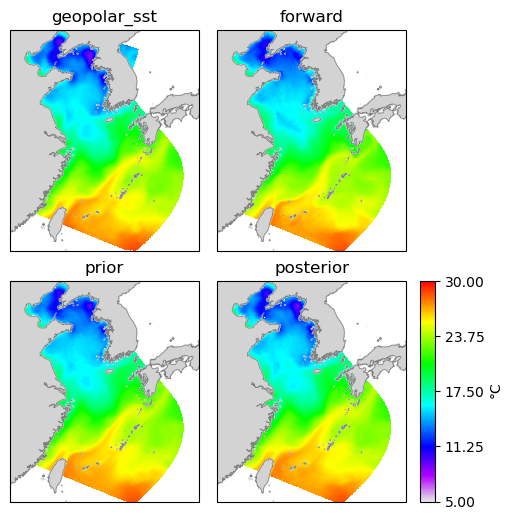

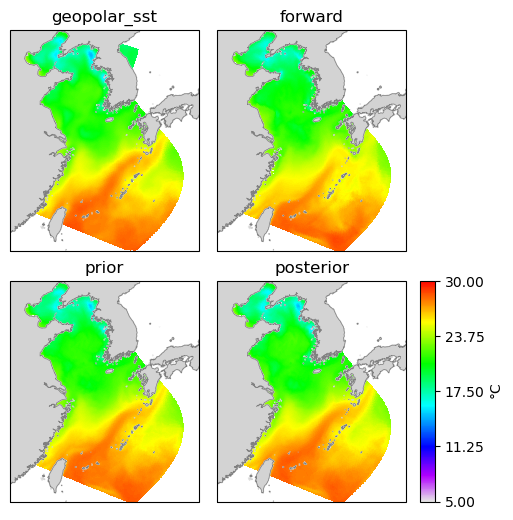

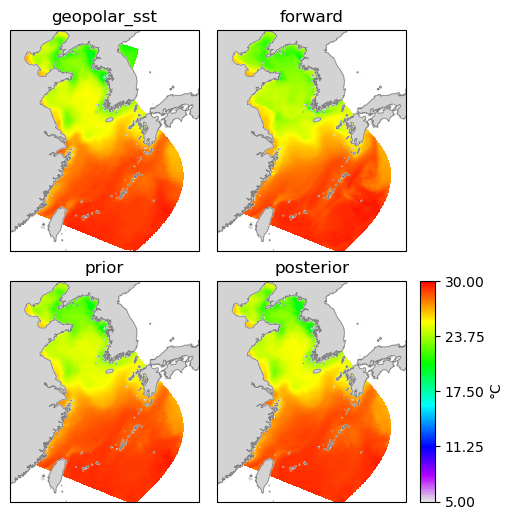

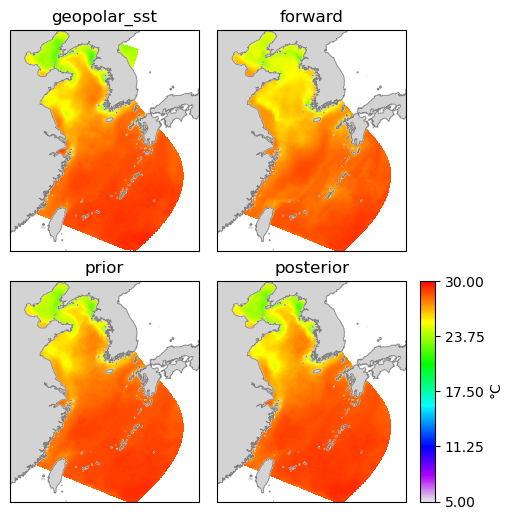

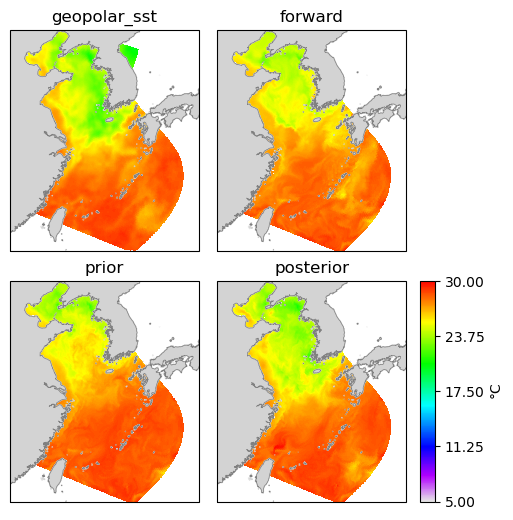

In [20]:
# monthly data contrast
for imonth in range(len(Obs_monthmean)):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    

    plot_func(0,0,
              Obs_monthmean.isel(time=imonth),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_monthmean.isel(ocean_time=imonth),
              my_title='forward',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(1,0,
              prior_monthmean.isel(ocean_time=imonth),
              my_title='prior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    p1=plot_func(1,1,
              post_monthmean.isel(ocean_time=imonth),
              my_title='posterior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(var_min,var_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_monthmean/%s.jpeg'%(imonth+5),bbox_inches='tight',dpi=400)

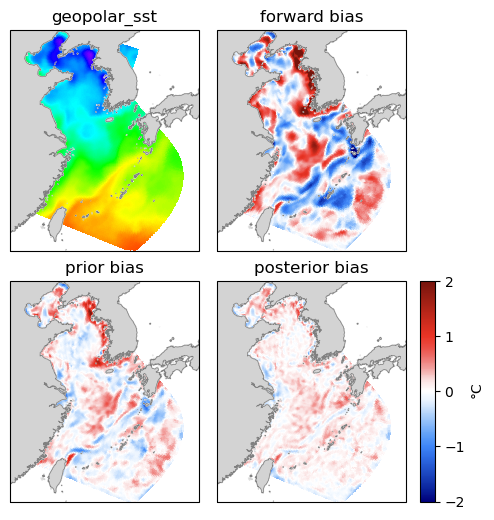

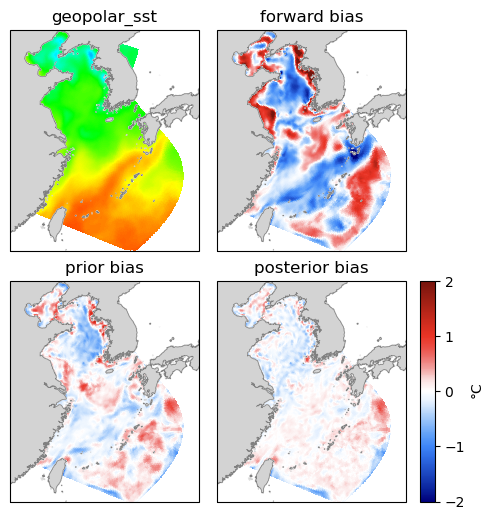

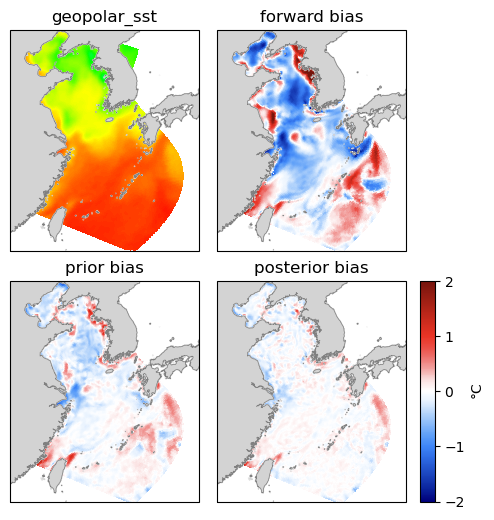

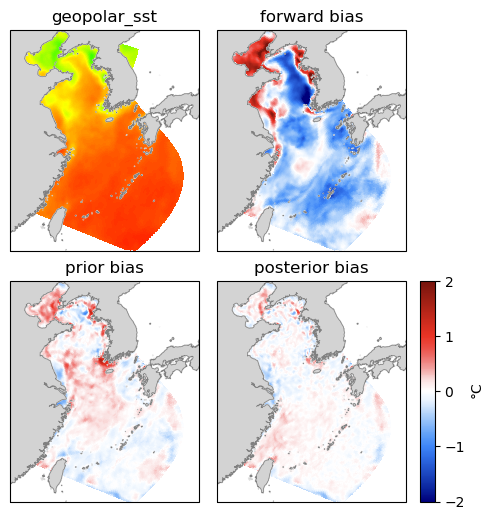

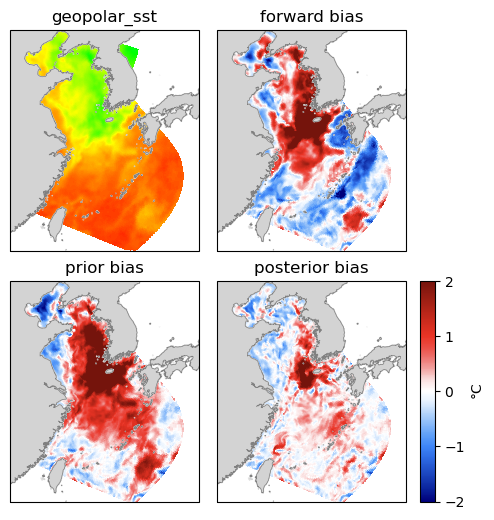

In [21]:
# monthly data bias contrast

# %matplotlib
# plot configuration

for imonth in range(len(Obs_monthmean)):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    plot_func(0,0,
              Obs_monthmean.isel(time=imonth),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(time=imonth),
              my_title='forward bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    plot_func(1,0,
              prior_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(time=imonth),
              my_title='prior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    p1=plot_func(1,1,
              post_monthmean.isel(ocean_time=imonth) - Obs_monthmean.isel(time=imonth),
              my_title='posterior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_monthbias/%s.jpeg'%(imonth+5),bbox_inches='tight',dpi=400)

KeyboardInterrupt: 

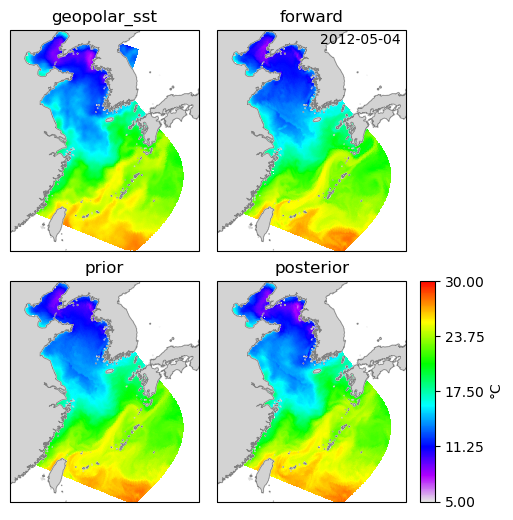

In [22]:
# plot daily mean contrast 


for iday in range(data_len):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    fig.text(0.48,0.87,str(prior_dailymean.ocean_time[iday].data)[0:10])
    plot_func(0,0,
              Obs_modgrd.isel(time=iday),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_dailymean.isel(ocean_time=iday),
              my_title='forward',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(1,0,
              prior_dailymean.isel(ocean_time=iday),
              my_title='prior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    p1=plot_func(1,1,
              post_dailymean.isel(ocean_time=iday),
              my_title='posterior',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(var_min,var_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_dailymean/%s.jpeg'%(str(prior_dailymean.ocean_time[iday].data)[0:10]),
                bbox_inches='tight',dpi=400)
    plt.close()

In [ ]:
# plot daily bias contrast 


for iday in range(data_len):
    fig, axs = plt.subplots(ncols=2, nrows=2, 
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
    # fig.
    #change the right to reduce the space between columns
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                        wspace=0.1, hspace=0.1)
    fig.text(0.48,0.87,str(prior_dailymean.ocean_time[iday].data)[0:10])
    plot_func(0,0,
              Obs_modgrd.isel(time=iday),
              my_title='geopolar_sst',
              my_cbar=my_sst,my_clabel='Celsius', 
              my_vmin=var_min, my_vmax=var_max)
    plot_func(0,1,
              fwd_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(time=iday),
              my_title='forward bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    plot_func(1,0,
              prior_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(time=iday),
              my_title='prior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)
    p1=plot_func(1,1,
              post_dailymean.isel(ocean_time=iday) - Obs_modgrd.isel(time=iday),
              my_title='posterior bias',
              my_cbar=my_div,my_clabel='Celsius', 
              my_vmin=bias_min, my_vmax=bias_max)

    position=fig.add_axes([ 0.62, 0.1075, 0.02, 0.36825,])
    cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
    cb.set_label('$\degree$C') 
    plt.savefig('./fig_dailybias/%s.jpeg'%(str(prior_dailymean.ocean_time[iday].data)[0:10]),
                bbox_inches='tight',dpi=400)
    plt.close()

In [196]:
# area configuration
area = 'bh'

if area == 'bh':
    eta_range = slice(280,360)
    xi_range = slice(0,80)
    lon_bdy = [116.5,123.5];
    lat_bdy = [36,42];
    fullname = 'Bohai Sea'
elif area == 'ys':
    eta_range = slice(220,305)
    xi_range = slice(105,200)
    lon_bdy = [122,128];
    lat_bdy = [34,38];
    fullname = 'Yellow Sea'
elif area =='cre':
    eta_range = slice(70,220)
    xi_range = slice(15,150)
    lon_bdy = [119.5,130.5];
    lat_bdy = [27,35];
    fullname = 'Changjiang River Esturay'

In [197]:
# specific area-mean time series

# calculating observation
Obs_areamean = Obs_modgrd.isel(eta_rho=eta_range,
                             xi_rho=xi_range).mean(axis=(1,2)).compute()
# calculating forward 
fwd_areamean = fwd_data.isel(eta_rho=eta_range,
                             xi_rho=xi_range).mean(axis=(1,2)).compute()
# calculating prior
prior_areamean = prior_data.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).mean(axis=(1,2)).compute()

# calculating posterior
post_areamean = post_data.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).mean(axis=(1,2)).compute()

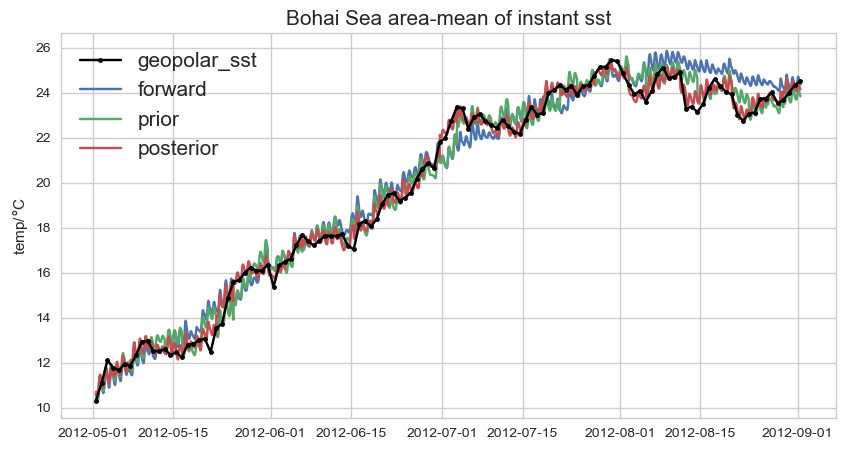

In [198]:
# specific area-mean time series
import seaborn as sns
my_palette = sns.color_palette("Blues", )
# plt.rcParams['font.size'] = 20
# my_palette = sns.diverging_palette(250, 20, l=65, center="light")
plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots( figsize = (10,5),
                       )

lo1, =ax.plot(Obs_areamean.time,Obs_areamean.data,
            color='k',marker='.',
            label='geopolar_sst',zorder=2)

ax.plot(fwd_areamean.ocean_time,fwd_areamean.data, 
        # color=my_palette[1],
            label='forward',
        zorder=1
           )

ax.plot(prior_areamean.ocean_time,prior_areamean.data,
        # color=my_palette[2],
       label='prior',
       zorder=1)


ax.plot(post_areamean.ocean_time,post_areamean.data,
        # color=my_palette[4],
       label='posterior',
       zorder=1)
ax.legend(loc='upper left',fontsize=15)
ax.set_title('%s area-mean of instant sst'%(fullname),fontsize=15)
ax.set_ylabel('temp/$\degree$C')

plt.savefig('./fig_timeseries/%s_areamean.jpeg'%(area),bbox_inches='tight',dpi=400)


In [199]:
# specific area-daily-mean (admean) time series

# calculating observation
Obs_admean = Obs_areamean.copy()
# calculating forward 
fwd_admean = fwd_dailymean.isel(eta_rho=eta_range,
                             xi_rho=xi_range).mean(axis=(1,2)).compute()
# calculating prior
prior_admean = prior_dailymean.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).mean(axis=(1,2)).compute()

# calculating posterior
post_admean = post_dailymean.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).mean(axis=(1,2)).compute()

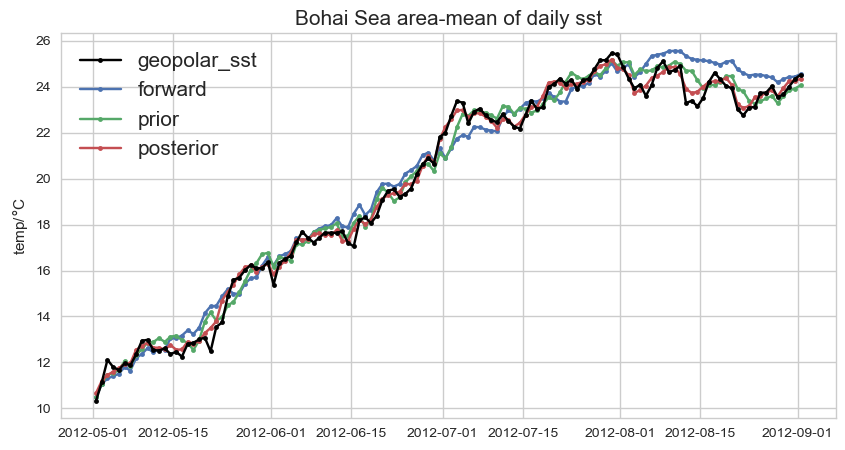

In [200]:
# specific area-daily-mean (admean) time series

# plt.rcParams['font.size'] = 20
# my_palette = sns.diverging_palette(250, 20, l=65, center="light")
plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots( figsize = (10,5),
                       )

lo1, =ax.plot(Obs_admean.time,Obs_admean.data,
            color='k',marker='.',
            label='geopolar_sst',zorder=2)

ax.plot(Obs_admean.time,fwd_admean.data, 
        marker='.',
            label='forward',
        zorder=1
           )

ax.plot(Obs_admean.time,prior_admean.data,
       marker='.',
       label='prior',
       zorder=1)


ax.plot(Obs_admean.time,post_admean.data,
        marker='.',
       label='posterior',
       zorder=1)
ax.legend(loc='upper left',fontsize=15)
ax.set_title('%s area-mean of daily sst' %(fullname),fontsize=15)
ax.set_ylabel('temp/$\degree$C')

plt.savefig('./fig_timeseries/%s_admean.jpeg'%(area),bbox_inches='tight',dpi=400)


In [201]:
# specific area daily area mean bias


# calculating forward 
fwd_areabias = (Obs_modgrd.isel(eta_rho=eta_range,
                             xi_rho=xi_range)
                -fwd_dailymean.isel(eta_rho=eta_range,
                             xi_rho=xi_range).data).mean(skipna=True,axis=(1,2))
# calculating prior
prior_areabias = (Obs_modgrd.isel(eta_rho=eta_range,
                             xi_rho=xi_range)
                  -prior_dailymean.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).data).mean(skipna=True,axis=(1,2))

# calculating posterior
post_areabias = (Obs_modgrd.isel(eta_rho=eta_range,
                             xi_rho=xi_range)
                 -post_dailymean.isel(eta_rho=eta_range,
                                 xi_rho=xi_range).data).mean(skipna=True,axis=(1,2))

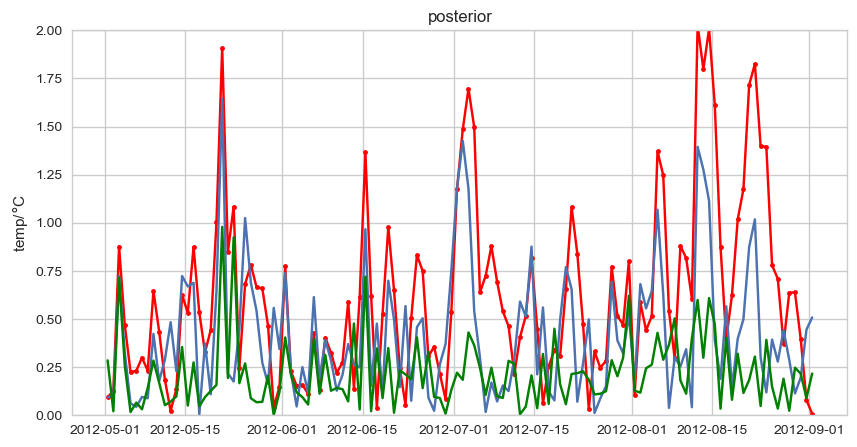

In [202]:
fig,ax = plt.subplots(figsize = (10,5),
                       )


ax.plot(fwd_areabias.time,np.abs(fwd_areabias.data), 
            color='r', marker='.'
           )

ax.set_title('forward')
# ax.tick_params('x',labelbottom=False)



ax.plot(prior_areabias.time,np.abs(prior_areabias.data))

ax.set_title('prior')
# ax.tick_params('x',labelbottom=False)


ax.plot(post_areabias.time,np.abs(post_areabias.data),color='g')
ax.set_title('posterior')
ax.set_ylabel('temp/$\degree$C')

ax.set_ylim([0,2])

plt.savefig('./fig_timeseries/%s_areabias.jpeg'%(area),bbox_inches='tight',dpi=400)


In [203]:
# specific area daily bias mean distribution

Obs_dmean = Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).mean(skipna=True,axis=0)
fwd_dbiasmean = (fwd_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)

prior_dbiasmean = (prior_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)

post_dbiasmean = (post_dailymean.isel(eta_rho=eta_range,
                                  xi_rho=xi_range)
                 -Obs_modgrd.isel(eta_rho=eta_range,
                                  xi_rho=xi_range).data
                ).mean(skipna=True,axis=0)


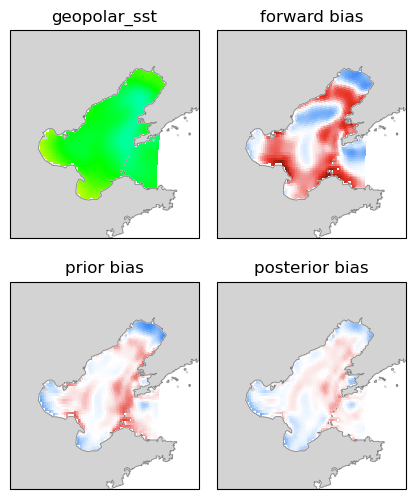

In [205]:

plt.style.use('default')
fig, axs = plt.subplots(2,2,
                            subplot_kw={'projection':ccrs.Mercator()},
                            figsize=(7.2,6)
                           )
if area == 'bh':
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.6,
                            wspace=0.1, hspace=0.1)


plot_func(0,0,
          Obs_dmean,
          my_title='geopolar_sst',
          # add_cb=True,
          my_cbar=my_sst,
          # my_clabel='Celsius', 
          my_vmin=var_min, my_vmax=var_max)
plot_func(0,1,
          fwd_dbiasmean,
          my_title='forward bias',
          # add_cb=True,
          my_cbar=my_div,
          # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)
plot_func(1,0,
          prior_dbiasmean,
          my_title='prior bias',
          # add_cb=True,
          my_cbar=my_div,
          # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)
p1=plot_func(1,1,
          post_dbiasmean,
          my_title='posterior bias',
             # add_cb=True,
          my_cbar=my_div,
             # my_clabel='Celsius', 
          my_vmin=bias_min, my_vmax=bias_max)

# position=fig.add_axes([ 0.62, 0.159, 0.02, 0.265,])
# cb = fig.colorbar(p1, cax = position,ticks = np.linspace(bias_min,bias_max,5))
cb.set_label('$\degree$C') 
plt.savefig('./fig_dailymean/%s_dailybiasmean.jpeg'%(area),
                bbox_inches='tight',dpi=400)